In [0]:
# get a trained model, a noisy piece of data, and feed the latter into the former

import os
from os import path
import numpy as np
import random as rnd
#from keras.models import load_model
import librosa
# DSP functions such as applying noise, RIRs, or data representation conversions

import pandas as pd
import time
import scipy

# generate seed from the time at which this script is run
rnd.seed(int(time.time()))
import matplotlib.pyplot as plt 

"""

#from libs.data_generator import DataGenerator
from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model
#from libs.model_utils import LossLayer
from libs.processing import s_to_reim, reim_to_s, make_fragments, unmake_fragments

"""

In [0]:



### FRAGMENTING AND RECONSTRUCTING FROM FRAGMENTS
def make_fragments(s, frag_hop_len, frag_win_len):
    print('entered make_fragments!')
    # convert T-F data into fragments
    n_frags = int((s.shape[1] - frag_win_len) / frag_hop_len + 1)
    print('just calculated n_frags!:{}'.format(n_frags) )
    def get_slice(i):
        lower_bound = i*frag_hop_len
        upper_bound = i*frag_hop_len+frag_win_len
        return s[:, lower_bound:upper_bound]
    frags = [get_slice(i) for i in range(n_frags)]
    return frags

def unmake_fragments(s_frag, frag_hop_len, frag_win_len):
    print('entered unmake_fragments!')
    # TODO get to work with arbitrary input shape?
    spec_length = (s_frag.shape[0]-1) * frag_hop_len + frag_win_len
    s = np.zeros((s_frag.shape[1], spec_length), dtype=s_frag.dtype)
    for i, frag in enumerate(s_frag):
        # TODO does this use the oldest or newest part?
        lower_bound = i*frag_hop_len
        upper_bound = i*frag_hop_len+frag_win_len
        s[:, lower_bound:upper_bound] = frag
    return s



### PRE/POST PROCESSING FUNCTIONS
# convert complex spectrograms to Re/Im representation
def s_to_reim(s):
    # remove a bin if odd number
    if s.shape[0] % 2 != 0:
        s = s[:-1]
    # split re/im
    re = np.real(s)
    im = np.imag(s)
    # stack
    reim = np.dstack((re, im))
    return reim


# convert Re/Im representation to complex spectrograms
def reim_to_s(reim):
    # extract real and imaginary components
    re = reim[..., 0]
    im = reim[..., 1]
    # combine into complex values
    s = re + 1j * im
    # add previously removed bin
    pad_shape = list(s.shape)
    pad_shape[-2] = 1
    pad_shape = tuple(pad_shape)
    padding = np.zeros(pad_shape)
    s = np.concatenate((s, padding), axis=-2)
    return s



### NOISING FUNCTIONS  
def white_noise(x, snr):
    print('Using white noise')
    
    N = max(x.shape)
    # N = len(x) alternatively
    sigma = np.sqrt( (x @ x.T) / (N * 10**(snr/10)) )
    noise = [sigma * rnd.uniform(-1,1) for k in range( N) ]
    
    return x+noise


def pink_noise(x, snr):
    """Generates pink noise using the Voss-McCartney algorithm.
        
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    print('Using pink noise')
    
    nrows = len(x) #x.shape
    ncols=16
    
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    sigma = np.sqrt( (x @ x.T) / (nrows * 10**(snr/10)) )
    noise= sigma*(total.values-np.mean(total.values)) / (max(total.values) - np.mean(total.values))
    
    return x+noise


def velvet_noise(x, SNR):
    print('Using velvet noise')
    
    N = max(x.shape)
    # N = len(x) alternatively
    sigma = np.sqrt( (x @ x.T) / (N * 10**(SNR/10)) )
    print('sigma = {0}'.format(sigma))
    rate_zero=0.95
    myVelvetNoise = [rnd.uniform(-1, 1) for k in range( N) ] #random numbers between -1 and 1
    noise = [sigma * ((vv> rate_zero) - (vv < -rate_zero)) for vv in myVelvetNoise]
    return x+noise#, params
  


# def take_file_as_noise(x, SNR):
#     # checking TODO
#     N = len(x)
#     sigma = np.sqrt( (x @ x.T) / (N * 10**(SNR/10)) )
#     def noising_prototype( filepath):
#         print('Using the following file as noise: {0}'.format(filepath))
# #        path = os.path.join(filepath + '.wav')
#         load_noise = np.load(filepath)
#         noise =  sigma * (load_noise - np.mean(load_noise)) + np.mean(load_noise) 
#         return noise
#     return noising_prototype
  
def take_file_as_noise(filepath):
    # checking TODO
    print('Using the following file as noise: {0}'.format(filepath))
    # path = os.path.join(filepath + '.wav')
    load_noise = np.load(filepath)
    
    def noising_prototype(x, SNR):
        N = len(x)
        sigma = np.sqrt( (x @ x.T) / (N * 10**(SNR/10)) )
        noise =  sigma * (load_noise - np.mean(load_noise)) + np.mean(load_noise) 
        return noise
    return noising_prototype


In [0]:
def denoise(model_name, model_path, input_path, output_path,
        sr, n_fft, hop_length, win_length, frag_hop_length, frag_win_length, 
        batch_size, cuda_device):

    print('[n] Applying model in {} at {} on data in {}'.format(model_name, model_path, input_path))
    print('[n] Denoising parameters: {}'.format({
        'model_name': model_name,
        'model_path': model_path,
        'input_path': input_path,
        'output_path': output_path,
        'cuda_device': cuda_device
    }))

    # set GPU devices
    os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device

    ## Input data handling
    print('[n] Loading data from {}...'.format(input_path))
    # load data from file name
    x_noisy, _ = librosa.core.load(input_path, sr=sr)
    # convert to TF-domain
    s = librosa.core.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # apply pre-processing (data representation)
    y_proc = s_to_reim(s)
    # split into fragments
    y_frags_noisy = make_fragments(y_proc, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    y_frags_noisy = np.array(y_frags_noisy)
    print('[n] Generated {} fragments with shape {}'.format(len(y_frags_noisy), y_frags_noisy[0].shape))
    # Normalization per fragment
    std_frag = np.empty(len(y_frags_noisy))
    for i, yy in enumerate(y_frags_noisy):
        std_frag[i] = np.std(yy)
        yy = (yy - np.mean(yy))/std_frag[i]

    # load trained model
    print('[n] Loading model from {}...'.format(model_path))
    lossfunc = load_autoencoder_lossfunc(model_name)
    _, _, model = load_autoencoder_model(model_path, {'lossfunc': lossfunc})
    # print model summary
    #model.summary()

    # prediction on data
    print('[n] Predicting with trained model...')
    y_frags_pred = model.predict(y_frags_noisy)
    print('[n] Prediction finished!')

    ## Perform inverse operations on data
    # Inverse normalization
    for i, yy in enumerate(y_frags_pred):
        yy = yy *std_frag[i] # + np.mean(ss)
    # undo batches
    y_pred = unmake_fragments(y_frags_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
    # convert to complex spectrogram
    s_pred = reim_to_s(y_pred)
    # get absolute spectrogram
    s_pred = np.abs(s_pred) ** 2
    # get waveform
    x_pred = librosa.istft(s_pred, hop_length=hop_length, win_length=win_length)
    
    # store cleaned audio as wav file
    librosa.output.write_wav(output_path, x_pred, sr=sr)

    # very slow at the beginning then very fast (real-time possible)
    #np.save('cleaned_data_pred', cleaned_data_pred)
    print('Cleaned data is reconstructed and stored at {}'.format(output_path))


    print('[n] Done!')



In [72]:
x, sr = librosa.load(librosa.util.example_audio_file(),sr=16000)
N = len(x)
t = np.arange(0,N/sr,1/sr)
SNR = 0
sigma = np.sqrt(x@(x.T)/(N*10**(SNR/10)));


x_noisy = x+velvet_noise(x, SNR)#x + [sigma* rnd.uniform(-.1,.1) for tt in range(len(t)) ]

# (x.shape, x_noisy.shape)

Using velvet noise
sigma = 0.10840618918189725


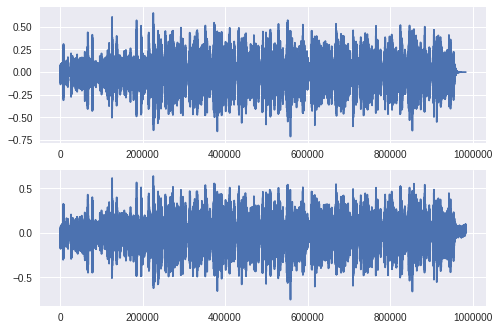

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1d88237710>,
 None)

In [59]:
plt.subplot(2,1,1), plt.plot(x),
plt.subplot(2,1,2), plt.plot(x_noisy), plt.show()

In [0]:
n_fft = 512
hop_length = 256
win_length  =512

frag_hop_length= 256
frag_win_length=512

In [91]:
s = librosa.core.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=frag_win_length)

# apply pre-processing (data representation)
y_proc = s_to_reim(s)

# split into fragments
y_frags_noisy = make_fragments(y_proc, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
y_frags_noisy = np.array(y_frags_noisy)
print('[n] Generated {} fragments with shape {}'.format(len(y_frags_noisy), y_frags_noisy[0].shape))

# Normalization per fragment
std_frag = np.empty(len(y_frags_noisy))
for i, yy in enumerate(y_frags_noisy):
    print(yy.shape)
    std_frag[i] = np.std(yy)
    yy = (yy - np.mean(yy))/std_frag[i]

entered make_fragments!
just calculated n_frags!:14
[n] Generated 14 fragments with shape (256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)


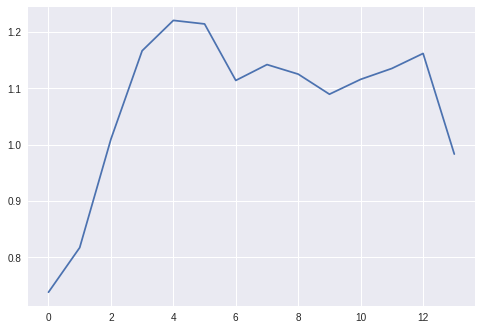

([<matplotlib.lines.Line2D at 0x7f1d8829d518>], None)

In [26]:
plt.plot(std_frag), plt.show()
# plt.plot(np.std(y_frags_noisy)), plt.show()

In [88]:
# s_noisy = librosa.core.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=frag_win_length)
# s_reim = s_to_reim(s_noisy)
# s_frag = make_fragments(s_reim, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)

# for i, yy in enumerate(s_frag):
#     yy = (yy - np.mean(yy))/std_frag[i]

    # prediction on data
print('[n] Predicting with trained model...')
y_frags_pred = y_frags_noisy# s_frag #to be simple, let just put the clean oe as the predicted one
print('[n] Prediction finished!')

# plt.subplot(2,1,1), plt.plot(x),
# plt.subplot(2,1,2), plt.plot(x_noisy), plt.show()

[n] Predicting with trained model...
[n] Prediction finished!


In [90]:
## Perform inverse operations on data
# Inverse normalization
for i, yy in enumerate(y_frags_pred):
    print(yy.shape)
    yy = yy *std_frag[i] # + np.mean(ss)
y_frags_pred = np.array(y_frags_pred)
print('y_frags_pred: ',y_frags_pred.shape)

# convert to complex spectrogram
s_pred = reim_to_s(y_frags_pred)
# undo batches
s_pred = unmake_fragments(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)

# get absolute spectrogram
s_pred = np.abs(s_pred) ** 2
# get waveform
x_pred = librosa.istft(s_pred, hop_length=hop_length, win_length=win_length)

(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
(256, 512, 2)
y_frags_pred:  (14, 256, 512, 2)
entered unmake_fragments!


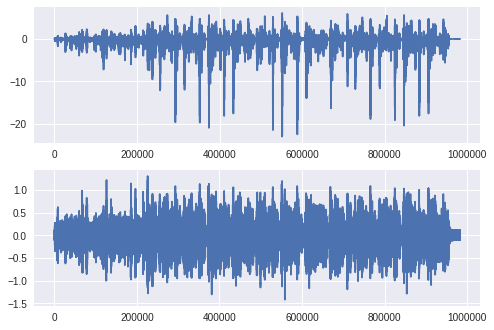

(1.3041483163833618, 6.1044416)

In [87]:
plt.subplot(2,1,1), plt.plot(x_pred),
plt.subplot(2,1,2), plt.plot(x_noisy), plt.show()
(np.max(x_noisy), np.max(x_pred))